# Tutorial Clustering: Indonesia Tourism Dataset
## Perbandingan K-Means dan Hierarchical Clustering

Tutorial ini mencakup:
1. **Eksplorasi Data** - Missing values, outliers, dan data quality
2. **Integrasi Data** - Menggabungkan beberapa file CSV
3. **Preprocessing** - Handling missing values, outliers, dan normalisasi
4. **Clustering** - K-Means dan Hierarchical dengan berbagai parameter
5. **Perbandingan** - Hasil dengan/tanpa preprocessing dan parameter berbeda

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 2. Load Data
### Dataset terdiri dari 4 file:
- `tourism_with_id.csv` - Data destinasi wisata dengan atribut lengkap
- `tourism_rating.csv` - Rating user untuk destinasi
- `user.csv` - Data pengguna
- `package_tourism.csv` - Paket wisata

In [2]:
# Load all datasets
tourism = pd.read_csv('tourism_with_id.csv')
ratings = pd.read_csv('tourism_rating.csv')
users = pd.read_csv('user.csv')
packages = pd.read_csv('package_tourism.csv')

print("Dataset shapes:")
print(f"Tourism: {tourism.shape}")
print(f"Ratings: {ratings.shape}")
print(f"Users: {users.shape}")
print(f"Packages: {packages.shape}")

Dataset shapes:
Tourism: (437, 13)
Ratings: (10000, 3)
Users: (300, 3)
Packages: (100, 7)


## 3. Exploratory Data Analysis (EDA)

In [3]:
# Preview tourism data
print("\n=== TOURISM DATA ===")
print(tourism.head())
print(f"\nColumns: {tourism.columns.tolist()}")
print(f"\nData types:\n{tourism.dtypes}")


=== TOURISM DATA ===
   Place_Id                         Place_Name  \
0         1                   Monumen Nasional   
1         2                           Kota Tua   
2         3                      Dunia Fantasi   
3         4  Taman Mini Indonesia Indah (TMII)   
4         5           Atlantis Water Adventure   

                                         Description       Category     City  \
0  Monumen Nasional atau yang populer disingkat d...         Budaya  Jakarta   
1  Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya  Jakarta   
2  Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan  Jakarta   
3  Taman Mini Indonesia Indah merupakan suatu kaw...  Taman Hiburan  Jakarta   
4  Atlantis Water Adventure atau dikenal dengan A...  Taman Hiburan  Jakarta   

    Price  Rating  Time_Minutes  \
0   20000     4.6          15.0   
1       0     4.6          90.0   
2  270000     4.6         360.0   
3   10000     4.5           NaN   
4   94000     4.5    

In [4]:
# Preview ratings data
print("\n=== RATINGS DATA ===")
print(ratings.head())
print(f"\nColumns: {ratings.columns.tolist()}")


=== RATINGS DATA ===
   User_Id  Place_Id  Place_Ratings
0        1       179              3
1        1       344              2
2        1         5              5
3        1       373              3
4        1       101              4

Columns: ['User_Id', 'Place_Id', 'Place_Ratings']


In [5]:
# Preview users data
print("\n=== USERS DATA ===")
print(users.head())
print(f"\nColumns: {users.columns.tolist()}")


=== USERS DATA ===
   User_Id                   Location  Age
0        1      Semarang, Jawa Tengah   20
1        2         Bekasi, Jawa Barat   21
2        3        Cirebon, Jawa Barat   23
3        4         Bekasi, Jawa Barat   21
4        5  Lampung, Sumatera Selatan   20

Columns: ['User_Id', 'Location', 'Age']


In [6]:
# Preview packages data
print("\n=== PACKAGES DATA ===")
print(packages.head())
print(f"\nColumns: {packages.columns.tolist()}")


=== PACKAGES DATA ===
   Package     City         Place_Tourism1      Place_Tourism2  \
0        1  Jakarta      Pasar Tanah Abang        Taman Ayodya   
1        2  Jakarta      Pasar Tanah Abang  Pasar Taman Puring   
2        3  Jakarta  Perpustakaan Nasional               Monas   
3        4  Jakarta           Pulau Tidung      Pulau Bidadari   
4        5  Jakarta  Museum Satria Mandala       Museum Wayang   

          Place_Tourism3                                     Place_Tourism4  \
0         Museum Tekstil                                                NaN   
1   Pasar Petak Sembilan                                                NaN   
2        Masjid Istiqlal                                                NaN   
3             Pulau Pari                                      Pulau Pramuka   
4  Museum Bahari Jakarta  Museum Macan (Modern and Contemporary Art in N...   

  Place_Tourism5  
0            NaN  
1            NaN  
2            NaN  
3  Pulau Pelangi  
4         

### 3.1 Check Missing Values

In [7]:
def check_missing_values(df, name):
    print(f"\n=== Missing Values in {name} ===")
    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)
    missing_table = pd.DataFrame({
        'Missing Count': missing,
        'Percentage': missing_pct
    })
    print(missing_table[missing_table['Missing Count'] > 0].sort_values('Missing Count', ascending=False))
    
    if missing.sum() == 0:
        print("No missing values found!")
    
    return missing_table

missing_tourism = check_missing_values(tourism, 'Tourism')
missing_ratings = check_missing_values(ratings, 'Ratings')
missing_users = check_missing_values(users, 'Users')
missing_packages = check_missing_values(packages, 'Packages')


=== Missing Values in Tourism ===
              Missing Count  Percentage
Unnamed: 11             437  100.000000
Time_Minutes            232   53.089245

=== Missing Values in Ratings ===
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []
No missing values found!

=== Missing Values in Users ===
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []
No missing values found!

=== Missing Values in Packages ===
                Missing Count  Percentage
Place_Tourism5             61        61.0
Place_Tourism4             34        34.0


### 3.2 Statistical Summary

In [8]:
# Statistical summary for tourism data
print("\n=== Tourism Data - Statistical Summary ===")
print(tourism.describe())


=== Tourism Data - Statistical Summary ===
         Place_Id          Price      Rating  Time_Minutes         Lat  \
count  437.000000     437.000000  437.000000    205.000000  437.000000   
mean   219.000000   24652.173913    4.442792     82.609756   -7.095438   
std    126.295289   66446.374709    0.208587     52.872339    0.727241   
min      1.000000       0.000000    3.400000     10.000000   -8.197894   
25%    110.000000       0.000000    4.300000     45.000000   -7.749590   
50%    219.000000    5000.000000    4.500000     60.000000   -7.020524   
75%    328.000000   20000.000000    4.600000    120.000000   -6.829411   
max    437.000000  900000.000000    5.000000    360.000000    1.078880   

             Long  Unnamed: 11  Unnamed: 12  
count  437.000000          0.0   437.000000  
mean   109.160142          NaN   219.000000  
std      1.962848          NaN   126.295289  
min    103.931398          NaN     1.000000  
25%    107.578369          NaN   110.000000  
50%    110.23

In [9]:
# Statistical summary for ratings data
print("\n=== Ratings Data - Statistical Summary ===")
print(ratings.describe())


=== Ratings Data - Statistical Summary ===
            User_Id      Place_Id  Place_Ratings
count  10000.000000  10000.000000   10000.000000
mean     151.292700    219.416400       3.066500
std       86.137374    126.228335       1.379952
min        1.000000      1.000000       1.000000
25%       77.000000    108.750000       2.000000
50%      151.000000    220.000000       3.000000
75%      226.000000    329.000000       4.000000
max      300.000000    437.000000       5.000000


### 3.3 Check for Duplicates

In [10]:
print(f"Tourism duplicates: {tourism.duplicated().sum()}")
print(f"Ratings duplicates: {ratings.duplicated().sum()}")
print(f"Users duplicates: {users.duplicated().sum()}")
print(f"Packages duplicates: {packages.duplicated().sum()}")

Tourism duplicates: 0
Ratings duplicates: 79
Users duplicates: 0
Packages duplicates: 0


### 3.4 Check Outliers (for numerical columns)

In [11]:
def detect_outliers_iqr(df, columns):
    outliers_dict = {}
    
    for col in columns:
        if df[col].dtype in ['int64', 'float64']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outliers_dict[col] = len(outliers)
    
    return outliers_dict

# Check outliers in tourism data (numerical columns only)
numeric_cols = tourism.select_dtypes(include=[np.number]).columns.tolist()
print("\n=== Outliers Detection (IQR Method) ===")
outliers = detect_outliers_iqr(tourism, numeric_cols)
for col, count in outliers.items():
    print(f"{col}: {count} outliers")


=== Outliers Detection (IQR Method) ===
Place_Id: 0 outliers
Price: 40 outliers
Rating: 3 outliers
Time_Minutes: 4 outliers
Lat: 1 outliers
Long: 0 outliers
Unnamed: 11: 0 outliers
Unnamed: 12: 0 outliers


### 3.5 Visualize Distributions

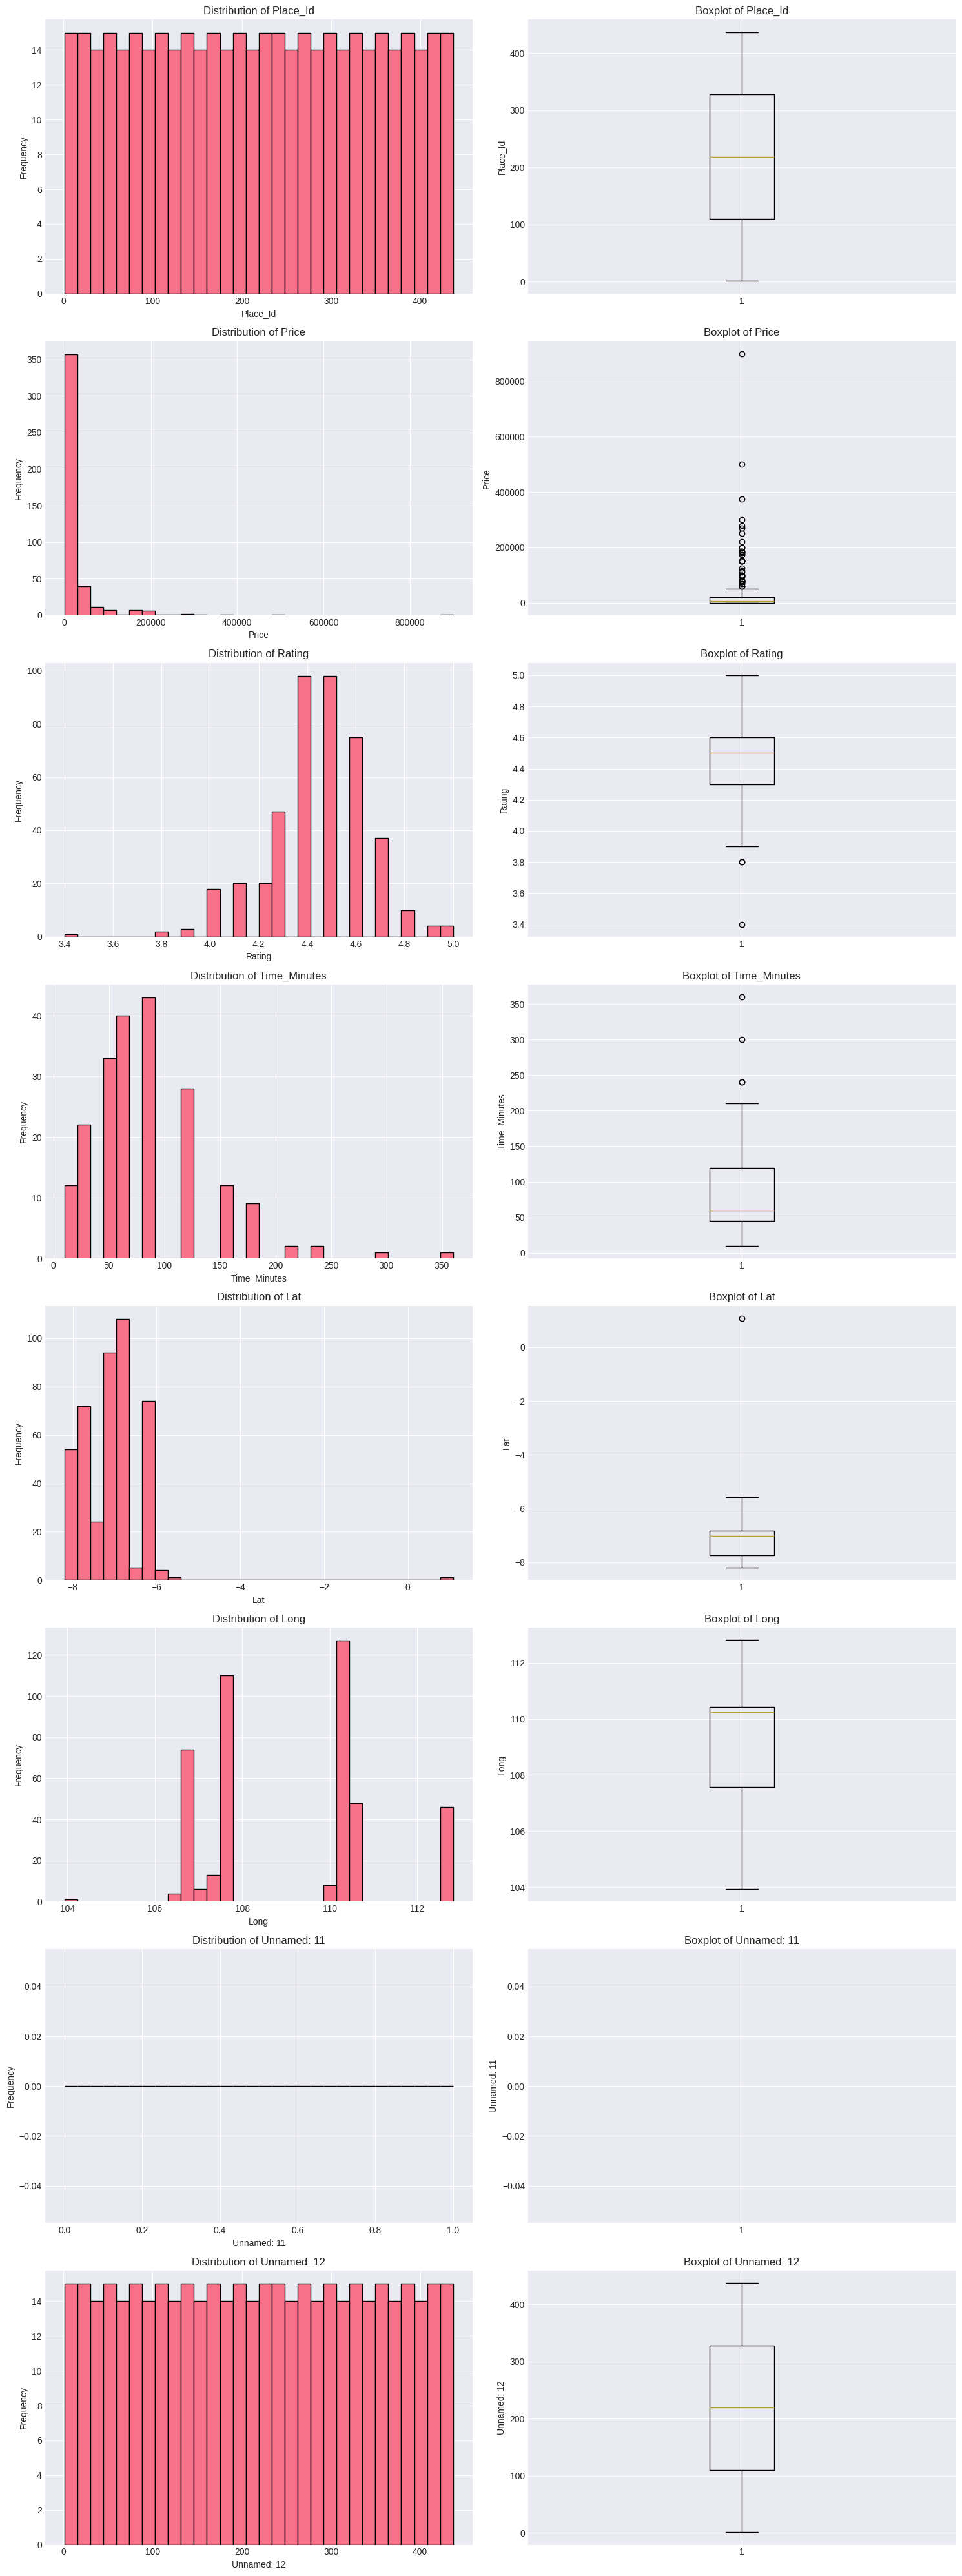

In [12]:
# Distribution of numerical features in tourism data
numeric_cols = tourism.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 0:
    fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(15, 5*len(numeric_cols)))
    
    if len(numeric_cols) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, col in enumerate(numeric_cols):
        # Histogram
        axes[idx, 0].hist(tourism[col].dropna(), bins=30, edgecolor='black')
        axes[idx, 0].set_title(f'Distribution of {col}')
        axes[idx, 0].set_xlabel(col)
        axes[idx, 0].set_ylabel('Frequency')
        
        # Boxplot
        axes[idx, 1].boxplot(tourism[col].dropna())
        axes[idx, 1].set_title(f'Boxplot of {col}')
        axes[idx, 1].set_ylabel(col)
    
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found for visualization")

## 4. Data Integration
### Menggabungkan dataset untuk mendapatkan informasi yang lebih lengkap

In [13]:
# Aggregate ratings for each place
ratings_agg = ratings.groupby('Place_Id').agg({
    'Place_Ratings': ['mean', 'count', 'std']
}).reset_index()

ratings_agg.columns = ['Place_Id', 'Avg_Rating', 'Rating_Count', 'Rating_Std']
ratings_agg['Rating_Std'] = ratings_agg['Rating_Std'].fillna(0)  # Fill NaN std with 0

print("\n=== Aggregated Ratings ===")
print(ratings_agg.head())
print(f"Shape: {ratings_agg.shape}")


=== Aggregated Ratings ===
   Place_Id  Avg_Rating  Rating_Count  Rating_Std
0         1    3.722222            18    1.447332
1         2    2.840000            25    1.374773
2         3    2.526316            19    1.540866
3         4    2.857143            21    1.492840
4         5    3.520000            25    1.326650
Shape: (437, 4)


In [14]:
# Merge tourism data with aggregated ratings
tourism_merged = tourism.merge(ratings_agg, on='Place_Id', how='left')

print("\n=== Merged Tourism Data ===")
print(tourism_merged.head())
print(f"\nShape: {tourism_merged.shape}")
print(f"Columns: {tourism_merged.columns.tolist()}")


=== Merged Tourism Data ===
   Place_Id                         Place_Name  \
0         1                   Monumen Nasional   
1         2                           Kota Tua   
2         3                      Dunia Fantasi   
3         4  Taman Mini Indonesia Indah (TMII)   
4         5           Atlantis Water Adventure   

                                         Description       Category     City  \
0  Monumen Nasional atau yang populer disingkat d...         Budaya  Jakarta   
1  Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya  Jakarta   
2  Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan  Jakarta   
3  Taman Mini Indonesia Indah merupakan suatu kaw...  Taman Hiburan  Jakarta   
4  Atlantis Water Adventure atau dikenal dengan A...  Taman Hiburan  Jakarta   

    Price  Rating  Time_Minutes  \
0   20000     4.6          15.0   
1       0     4.6          90.0   
2  270000     4.6         360.0   
3   10000     4.5           NaN   
4   94000     

## 5. Data Preprocessing
### 5.1 Identify Features for Clustering

In [15]:
# Select numerical features for clustering
# Exclude ID columns and names
exclude_cols = ['Place_Id', 'Place_Name']
categorical_cols = tourism_merged.select_dtypes(include=['object']).columns.tolist()
numerical_cols = [col for col in tourism_merged.select_dtypes(include=[np.number]).columns 
                  if col not in exclude_cols]

print(f"Numerical columns for clustering: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

Numerical columns for clustering: ['Price', 'Rating', 'Time_Minutes', 'Lat', 'Long', 'Unnamed: 11', 'Unnamed: 12', 'Avg_Rating', 'Rating_Count', 'Rating_Std']
Categorical columns: ['Place_Name', 'Description', 'Category', 'City', 'Coordinate']


In [16]:
# Create a clean dataset for clustering
# For this tutorial, we'll focus on numerical features
clustering_data = tourism_merged[numerical_cols].copy()

print(f"\nClustering data shape: {clustering_data.shape}")
print(f"\nMissing values:")
print(clustering_data.isnull().sum())


Clustering data shape: (437, 10)

Missing values:
Price             0
Rating            0
Time_Minutes    232
Lat               0
Long              0
Unnamed: 11     437
Unnamed: 12       0
Avg_Rating        0
Rating_Count      0
Rating_Std        0
dtype: int64


### 5.2 Handle Missing Values

In [17]:
# Fill missing values with median (robust to outliers)
clustering_data_filled = clustering_data.fillna(clustering_data.median())

print(f"Missing values after filling:")
print(clustering_data_filled.isnull().sum().sum())

Missing values after filling:
437


### 5.3 Handle Outliers (Optional - using IQR capping)

In [18]:
def cap_outliers(df):
    """Cap outliers using IQR method"""
    df_capped = df.copy()
    
    for col in df_capped.columns:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap the outliers
        df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df_capped

clustering_data_capped = cap_outliers(clustering_data_filled)
print("Outliers capped successfully!")

Outliers capped successfully!


### 5.4 Feature Scaling

In [19]:
# Standardization (Z-score normalization)
scaler_standard = StandardScaler()
clustering_data_scaled = scaler_standard.fit_transform(clustering_data_capped)
clustering_data_scaled_df = pd.DataFrame(clustering_data_scaled, 
                                          columns=clustering_data_capped.columns)

print("\n=== Data After Preprocessing (Scaled) ===")
print(clustering_data_scaled_df.head())
print(f"\nShape: {clustering_data_scaled_df.shape}")
print(f"\nMean of features (should be ~0): {clustering_data_scaled_df.mean().values}")
print(f"\nStd of features (should be ~1): {clustering_data_scaled_df.std().values}")


=== Data After Preprocessing (Scaled) ===
      Price    Rating  Time_Minutes       Lat      Long  Unnamed: 11  \
0  0.393637  0.766075           0.0  1.515263 -1.189936          NaN   
1 -0.781761  0.766075           0.0  1.576438 -1.195051          NaN   
2  2.156734  0.766075           0.0  1.596424 -1.186679          NaN   
3 -0.194062  0.274843           0.0  1.309356 -1.155251          NaN   
4  2.156734  0.274843           0.0  1.598243 -1.183825          NaN   

   Unnamed: 12  Avg_Rating  Rating_Count  Rating_Std  
0    -1.728092    2.166499     -1.022484    0.557277  
1    -1.720165   -0.755649      0.452883    0.015481  
2    -1.712238   -1.794652     -0.811717    1.255685  
3    -1.704311   -0.698867     -0.390184    0.897078  
4    -1.696384    1.496687      0.452883   -0.343847  

Shape: (437, 10)

Mean of features (should be ~0): [-1.21946694e-17  4.39008098e-16  0.00000000e+00 -2.11374269e-16
 -1.75603239e-15             nan  0.00000000e+00 -2.01212045e-16
  1.21946694

### 5.5 Correlation Analysis

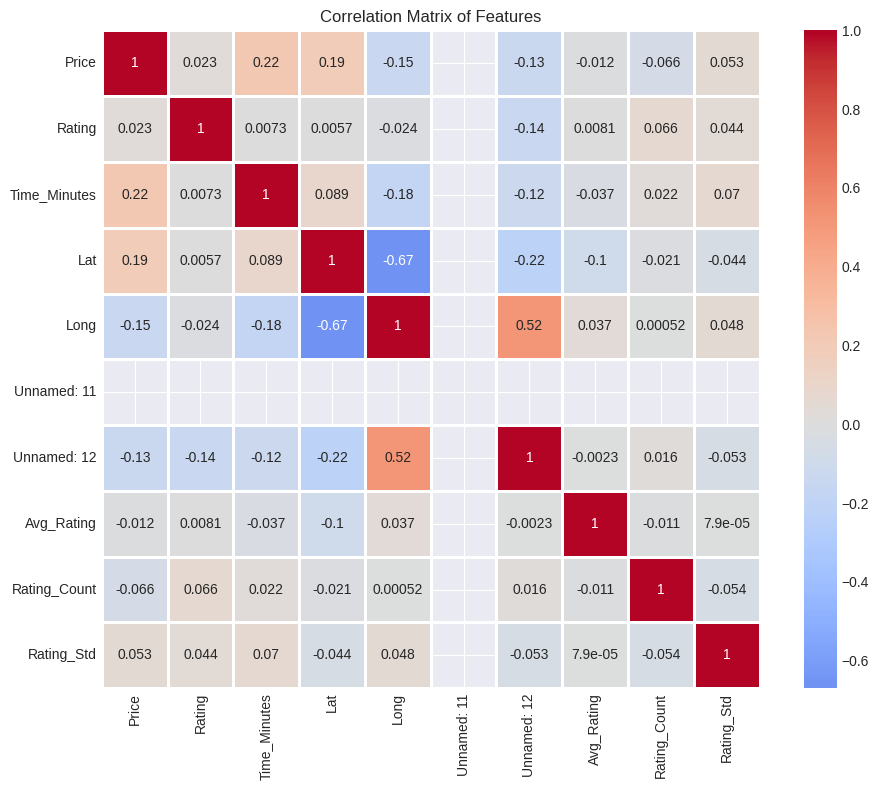

In [20]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = clustering_data_filled.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

## 6. K-Means Clustering
### 6.1 Elbow Method - Find Optimal K

In [21]:
# Elbow method
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clustering_data_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal K')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### 6.2 Silhouette Analysis

In [ ]:
# Silhouette scores for different K values
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(clustering_data_scaled)
    score = silhouette_score(clustering_data_scaled, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal K')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal K based on Silhouette Score: {optimal_k}")

### 6.3 K-Means with Preprocessing (Optimal K)

In [ ]:
# K-Means with optimal K (let's use K=4 as example, adjust based on your elbow/silhouette)
optimal_k = 4

kmeans_preprocessed = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_kmeans_preprocessed = kmeans_preprocessed.fit_predict(clustering_data_scaled)

# Calculate metrics
silhouette_kmeans = silhouette_score(clustering_data_scaled, labels_kmeans_preprocessed)
davies_bouldin_kmeans = davies_bouldin_score(clustering_data_scaled, labels_kmeans_preprocessed)
calinski_kmeans = calinski_harabasz_score(clustering_data_scaled, labels_kmeans_preprocessed)

print(f"\n=== K-Means with Preprocessing (K={optimal_k}) ===")
print(f"Silhouette Score: {silhouette_kmeans:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_kmeans:.4f} (lower is better)")
print(f"Calinski-Harabasz Index: {calinski_kmeans:.4f} (higher is better)")
print(f"\nCluster distribution:")
print(pd.Series(labels_kmeans_preprocessed).value_counts().sort_index())

### 6.4 K-Means WITHOUT Preprocessing (untuk perbandingan)

In [ ]:
# K-Means WITHOUT scaling/outlier handling
kmeans_no_preprocess = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_kmeans_no_preprocess = kmeans_no_preprocess.fit_predict(clustering_data_filled)

# Calculate metrics
silhouette_kmeans_no = silhouette_score(clustering_data_filled, labels_kmeans_no_preprocess)
davies_bouldin_kmeans_no = davies_bouldin_score(clustering_data_filled, labels_kmeans_no_preprocess)
calinski_kmeans_no = calinski_harabasz_score(clustering_data_filled, labels_kmeans_no_preprocess)

print(f"\n=== K-Means WITHOUT Preprocessing (K={optimal_k}) ===")
print(f"Silhouette Score: {silhouette_kmeans_no:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_kmeans_no:.4f} (lower is better)")
print(f"Calinski-Harabasz Index: {calinski_kmeans_no:.4f} (higher is better)")
print(f"\nCluster distribution:")
print(pd.Series(labels_kmeans_no_preprocess).value_counts().sort_index())

### 6.5 Comparison: With vs Without Preprocessing

In [ ]:
# Comparison table
comparison_kmeans = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'],
    'With Preprocessing': [silhouette_kmeans, davies_bouldin_kmeans, calinski_kmeans],
    'Without Preprocessing': [silhouette_kmeans_no, davies_bouldin_kmeans_no, calinski_kmeans_no]
})

print("\n=== K-Means: Impact of Preprocessing ===")
print(comparison_kmeans)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index']
for idx, metric in enumerate(metrics):
    values = comparison_kmeans[comparison_kmeans['Metric'] == metric][['With Preprocessing', 'Without Preprocessing']].values[0]
    axes[idx].bar(['With Preprocessing', 'Without Preprocessing'], values, color=['green', 'orange'])
    axes[idx].set_title(metric)
    axes[idx].set_ylabel('Score')
    
plt.tight_layout()
plt.show()

### 6.6 Test Different K Values (Parameter Tuning)

In [ ]:
# Test different K values
k_values = [3, 4, 5, 6]
results_different_k = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(clustering_data_scaled)
    
    silhouette = silhouette_score(clustering_data_scaled, labels)
    davies_bouldin = davies_bouldin_score(clustering_data_scaled, labels)
    calinski = calinski_harabasz_score(clustering_data_scaled, labels)
    
    results_different_k.append({
        'K': k,
        'Silhouette': silhouette,
        'Davies-Bouldin': davies_bouldin,
        'Calinski-Harabasz': calinski
    })

results_k_df = pd.DataFrame(results_different_k)
print("\n=== K-Means: Different K Values ===")
print(results_k_df)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(results_k_df['K'], results_k_df['Silhouette'], 'bo-', linewidth=2, markersize=8)
axes[0].set_title('Silhouette Score vs K')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Silhouette Score')
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_k_df['K'], results_k_df['Davies-Bouldin'], 'ro-', linewidth=2, markersize=8)
axes[1].set_title('Davies-Bouldin Index vs K')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].grid(True, alpha=0.3)

axes[2].plot(results_k_df['K'], results_k_df['Calinski-Harabasz'], 'go-', linewidth=2, markersize=8)
axes[2].set_title('Calinski-Harabasz Index vs K')
axes[2].set_xlabel('K')
axes[2].set_ylabel('Calinski-Harabasz Index')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Hierarchical Clustering
### 7.1 Dendrogram

In [ ]:
# Create dendrogram (using sample of data if too large)
sample_size = min(100, len(clustering_data_scaled))
sample_indices = np.random.choice(len(clustering_data_scaled), sample_size, replace=False)
sample_data = clustering_data_scaled[sample_indices]

# Different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for idx, method in enumerate(linkage_methods):
    Z = linkage(sample_data, method=method)
    dendrogram(Z, ax=axes[idx])
    axes[idx].set_title(f'Dendrogram - {method.capitalize()} Linkage')
    axes[idx].set_xlabel('Sample Index')
    axes[idx].set_ylabel('Distance')

plt.tight_layout()
plt.show()

### 7.2 Hierarchical Clustering with Preprocessing

In [ ]:
# Hierarchical clustering with preprocessing (ward linkage)
hierarchical_preprocessed = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
labels_hierarchical_preprocessed = hierarchical_preprocessed.fit_predict(clustering_data_scaled)

# Calculate metrics
silhouette_hierarchical = silhouette_score(clustering_data_scaled, labels_hierarchical_preprocessed)
davies_bouldin_hierarchical = davies_bouldin_score(clustering_data_scaled, labels_hierarchical_preprocessed)
calinski_hierarchical = calinski_harabasz_score(clustering_data_scaled, labels_hierarchical_preprocessed)

print(f"\n=== Hierarchical Clustering with Preprocessing (K={optimal_k}, Ward linkage) ===")
print(f"Silhouette Score: {silhouette_hierarchical:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_hierarchical:.4f} (lower is better)")
print(f"Calinski-Harabasz Index: {calinski_hierarchical:.4f} (higher is better)")
print(f"\nCluster distribution:")
print(pd.Series(labels_hierarchical_preprocessed).value_counts().sort_index())

### 7.3 Hierarchical Clustering WITHOUT Preprocessing

In [ ]:
# Hierarchical clustering WITHOUT preprocessing
hierarchical_no_preprocess = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
labels_hierarchical_no_preprocess = hierarchical_no_preprocess.fit_predict(clustering_data_filled)

# Calculate metrics
silhouette_hierarchical_no = silhouette_score(clustering_data_filled, labels_hierarchical_no_preprocess)
davies_bouldin_hierarchical_no = davies_bouldin_score(clustering_data_filled, labels_hierarchical_no_preprocess)
calinski_hierarchical_no = calinski_harabasz_score(clustering_data_filled, labels_hierarchical_no_preprocess)

print(f"\n=== Hierarchical Clustering WITHOUT Preprocessing (K={optimal_k}, Ward linkage) ===")
print(f"Silhouette Score: {silhouette_hierarchical_no:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_hierarchical_no:.4f} (lower is better)")
print(f"Calinski-Harabasz Index: {calinski_hierarchical_no:.4f} (higher is better)")
print(f"\nCluster distribution:")
print(pd.Series(labels_hierarchical_no_preprocess).value_counts().sort_index())

### 7.4 Test Different Linkage Methods

In [ ]:
# Test different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
results_linkage = []

for method in linkage_methods:
    hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage=method)
    labels = hierarchical.fit_predict(clustering_data_scaled)
    
    silhouette = silhouette_score(clustering_data_scaled, labels)
    davies_bouldin = davies_bouldin_score(clustering_data_scaled, labels)
    calinski = calinski_harabasz_score(clustering_data_scaled, labels)
    
    results_linkage.append({
        'Linkage': method,
        'Silhouette': silhouette,
        'Davies-Bouldin': davies_bouldin,
        'Calinski-Harabasz': calinski
    })

results_linkage_df = pd.DataFrame(results_linkage)
print("\n=== Hierarchical Clustering: Different Linkage Methods ===")
print(results_linkage_df)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
x_pos = np.arange(len(linkage_methods))

axes[0].bar(x_pos, results_linkage_df['Silhouette'])
axes[0].set_title('Silhouette Score by Linkage Method')
axes[0].set_xlabel('Linkage Method')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(linkage_methods)

axes[1].bar(x_pos, results_linkage_df['Davies-Bouldin'], color='orange')
axes[1].set_title('Davies-Bouldin Index by Linkage Method')
axes[1].set_xlabel('Linkage Method')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(linkage_methods)

axes[2].bar(x_pos, results_linkage_df['Calinski-Harabasz'], color='green')
axes[2].set_title('Calinski-Harabasz Index by Linkage Method')
axes[2].set_xlabel('Linkage Method')
axes[2].set_ylabel('Calinski-Harabasz Index')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(linkage_methods)

plt.tight_layout()
plt.show()

### 7.5 Test Different Number of Clusters

In [ ]:
# Test different number of clusters for hierarchical
k_values_hier = [3, 4, 5, 6]
results_hier_k = []

for k in k_values_hier:
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hierarchical.fit_predict(clustering_data_scaled)
    
    silhouette = silhouette_score(clustering_data_scaled, labels)
    davies_bouldin = davies_bouldin_score(clustering_data_scaled, labels)
    calinski = calinski_harabasz_score(clustering_data_scaled, labels)
    
    results_hier_k.append({
        'K': k,
        'Silhouette': silhouette,
        'Davies-Bouldin': davies_bouldin,
        'Calinski-Harabasz': calinski
    })

results_hier_k_df = pd.DataFrame(results_hier_k)
print("\n=== Hierarchical Clustering: Different K Values ===")
print(results_hier_k_df)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(results_hier_k_df['K'], results_hier_k_df['Silhouette'], 'bo-', linewidth=2, markersize=8)
axes[0].set_title('Silhouette Score vs K (Hierarchical)')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Silhouette Score')
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_hier_k_df['K'], results_hier_k_df['Davies-Bouldin'], 'ro-', linewidth=2, markersize=8)
axes[1].set_title('Davies-Bouldin Index vs K (Hierarchical)')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].grid(True, alpha=0.3)

axes[2].plot(results_hier_k_df['K'], results_hier_k_df['Calinski-Harabasz'], 'go-', linewidth=2, markersize=8)
axes[2].set_title('Calinski-Harabasz Index vs K (Hierarchical)')
axes[2].set_xlabel('K')
axes[2].set_ylabel('Calinski-Harabasz Index')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Visualization of Clustering Results
### 8.1 PCA for 2D Visualization

In [ ]:
# Apply PCA for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(clustering_data_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

### 8.2 Visualize K-Means Results

In [ ]:
# Visualize K-Means clustering
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# With preprocessing
scatter1 = axes[0].scatter(data_pca[:, 0], data_pca[:, 1], 
                           c=labels_kmeans_preprocessed, cmap='viridis', 
                           alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title(f'K-Means WITH Preprocessing (K={optimal_k})')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Without preprocessing (need to transform to same PCA space)
data_pca_no_preprocess = pca.transform(scaler_standard.transform(clustering_data_filled))
scatter2 = axes[1].scatter(data_pca_no_preprocess[:, 0], data_pca_no_preprocess[:, 1], 
                           c=labels_kmeans_no_preprocess, cmap='viridis', 
                           alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_title(f'K-Means WITHOUT Preprocessing (K={optimal_k})')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

### 8.3 Visualize Hierarchical Clustering Results

In [ ]:
# Visualize Hierarchical clustering
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# With preprocessing
scatter1 = axes[0].scatter(data_pca[:, 0], data_pca[:, 1], 
                           c=labels_hierarchical_preprocessed, cmap='plasma', 
                           alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title(f'Hierarchical WITH Preprocessing (K={optimal_k})')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Without preprocessing
scatter2 = axes[1].scatter(data_pca_no_preprocess[:, 0], data_pca_no_preprocess[:, 1], 
                           c=labels_hierarchical_no_preprocess, cmap='plasma', 
                           alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_title(f'Hierarchical WITHOUT Preprocessing (K={optimal_k})')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

### 8.4 Compare K-Means vs Hierarchical

In [ ]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-Means
scatter1 = axes[0].scatter(data_pca[:, 0], data_pca[:, 1], 
                           c=labels_kmeans_preprocessed, cmap='viridis', 
                           alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title(f'K-Means Clustering (K={optimal_k})')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Hierarchical
scatter2 = axes[1].scatter(data_pca[:, 0], data_pca[:, 1], 
                           c=labels_hierarchical_preprocessed, cmap='plasma', 
                           alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_title(f'Hierarchical Clustering (K={optimal_k})')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

## 9. Final Comparison and Summary

In [ ]:
# Create comprehensive comparison table
final_comparison = pd.DataFrame({
    'Method': [
        'K-Means (With Preprocessing)',
        'K-Means (Without Preprocessing)',
        'Hierarchical (With Preprocessing)',
        'Hierarchical (Without Preprocessing)'
    ],
    'Silhouette Score': [
        silhouette_kmeans,
        silhouette_kmeans_no,
        silhouette_hierarchical,
        silhouette_hierarchical_no
    ],
    'Davies-Bouldin Index': [
        davies_bouldin_kmeans,
        davies_bouldin_kmeans_no,
        davies_bouldin_hierarchical,
        davies_bouldin_hierarchical_no
    ],
    'Calinski-Harabasz Index': [
        calinski_kmeans,
        calinski_kmeans_no,
        calinski_hierarchical,
        calinski_hierarchical_no
    ]
})

print("\n" + "="*80)
print("FINAL COMPARISON: ALL METHODS")
print("="*80)
print(final_comparison.to_string(index=False))
print("\n" + "="*80)

In [ ]:
# Visualize final comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

methods = final_comparison['Method'].tolist()
x_pos = np.arange(len(methods))

# Silhouette Score
axes[0].bar(x_pos, final_comparison['Silhouette Score'], color=['green', 'lightgreen', 'blue', 'lightblue'])
axes[0].set_title('Silhouette Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score (Higher is Better)', fontsize=12)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(methods, rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Davies-Bouldin Index
axes[1].bar(x_pos, final_comparison['Davies-Bouldin Index'], color=['green', 'lightgreen', 'blue', 'lightblue'])
axes[1].set_title('Davies-Bouldin Index Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Index (Lower is Better)', fontsize=12)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(methods, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Calinski-Harabasz Index
axes[2].bar(x_pos, final_comparison['Calinski-Harabasz Index'], color=['green', 'lightgreen', 'blue', 'lightblue'])
axes[2].set_title('Calinski-Harabasz Index Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Index (Higher is Better)', fontsize=12)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(methods, rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Insights and Cluster Characteristics

In [ ]:
# Add cluster labels to original data
tourism_clustered = tourism_merged.copy()
tourism_clustered['Cluster_KMeans'] = labels_kmeans_preprocessed
tourism_clustered['Cluster_Hierarchical'] = labels_hierarchical_preprocessed

print("\n=== Sample of Clustered Data ===")
print(tourism_clustered.head(10))

In [ ]:
# Analyze cluster characteristics (K-Means)
print("\n=== K-Means Cluster Characteristics ===")
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_data = clustering_data_filled[labels_kmeans_preprocessed == cluster]
    print(f"Size: {len(cluster_data)} destinations")
    print("Mean values:")
    print(cluster_data.mean())

In [ ]:
# Analyze cluster characteristics (Hierarchical)
print("\n=== Hierarchical Cluster Characteristics ===")
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_data = clustering_data_filled[labels_hierarchical_preprocessed == cluster]
    print(f"Size: {len(cluster_data)} destinations")
    print("Mean values:")
    print(cluster_data.mean())

## 11. Key Takeaways

### Dampak Preprocessing:
- **Missing values handling**: Penting untuk menghindari error dan bias
- **Outlier treatment**: Meningkatkan stabilitas clustering
- **Feature scaling**: Sangat penting untuk algoritma berbasis jarak

### Perbandingan Algoritma:
- **K-Means**: 
  - Cepat dan efisien
  - Sensitif terhadap inisialisasi
  - Cluster berbentuk spherical
  
- **Hierarchical**: 
  - Tidak memerlukan jumlah cluster di awal
  - Dapat menangkap struktur hierarki
  - Lebih lambat untuk dataset besar

### Parameter Tuning:
- Jumlah cluster (K) sangat mempengaruhi hasil
- Linkage method pada hierarchical clustering memberikan hasil berbeda
- Gunakan multiple metrics untuk evaluasi yang komprehensif

## 12. Export Results (Optional)

In [ ]:
# Export clustered data to CSV
tourism_clustered.to_csv('tourism_clustered_results.csv', index=False)
print("Clustered data exported to 'tourism_clustered_results.csv'")

# Export comparison results
final_comparison.to_csv('clustering_comparison_results.csv', index=False)
print("Comparison results exported to 'clustering_comparison_results.csv'")